**Some tricks to combat overfitting**

* Part 1 [Intro to CNN (Dogs vs. Cats)](https://www.kaggle.com/imcr00z/intro-to-cnn-dogs-vs-cats)
* Part 2
* Part 3 [Transfer Learning (Dogs vs. Cats) 98% acc.](https://www.kaggle.com/imcr00z/transfer-learning-dogs-vs-cats-98-acc)

In this part i use augmentation and dropout layers to reduce overfitting and increase the predictive power of the model.

In [1]:
import os
import tqdm
import shutil
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/dogs-vs-cats/test1.zip
/kaggle/input/dogs-vs-cats/train.zip
/kaggle/input/dogs-vs-cats/sampleSubmission.csv


# Load data
Copied from my [Intro to CNN (Dogs vs. Cats)](http://https://www.kaggle.com/imcr00z/intro-to-cnn-dogs-vs-cats)

In [3]:
# !rm -rf /kaggle/content

In [4]:
CONTENT_DIR = '/kaggle/content'

TRAIN_DIR = CONTENT_DIR + '/train'
TRAIN_DIR_DOG = TRAIN_DIR + '/dog'
TRAIN_DIR_CAT = TRAIN_DIR + '/cat'

VALID_DIR = CONTENT_DIR + '/valid'
VALID_DIR_DOG = VALID_DIR + '/dog'
VALID_DIR_CAT = VALID_DIR + '/cat'

if not os.path.exists(CONTENT_DIR):
    import zipfile
    with zipfile.ZipFile('/kaggle/input/dogs-vs-cats/train.zip', 'r') as zipf:
        zipf.extractall(CONTENT_DIR)

    # Split cats and dogs images to train and valid datasets
    img_filenames = os.listdir(TRAIN_DIR)
    print('Num of images:', len(img_filenames))

    dog_filenames = [fn for fn in img_filenames if fn.startswith('dog')]
    cat_filenames = [fn for fn in img_filenames if fn.startswith('cat')]

    dataset_filenames = train_test_split(
        dog_filenames, cat_filenames, test_size=0.1, shuffle=True, random_state=42
    )

    train_dog_total, valid_dog_total, train_cat_total, valid_cat_total = [len(fns) for fns in dataset_filenames]
    train_total = train_dog_total + train_cat_total
    valid_total = valid_dog_total + valid_cat_total
    print('Train: {}, test: {}'.format(train_total, valid_total))

    # Move images
    make_dirs = [TRAIN_DIR_DOG, VALID_DIR_DOG, TRAIN_DIR_CAT, VALID_DIR_CAT]
    for dir, fns in zip(make_dirs, dataset_filenames):
        os.makedirs(dir, exist_ok=True)
        for fn in tqdm.tqdm(fns):
            shutil.move(os.path.join(TRAIN_DIR, fn), dir)
        print('elements in {}: {}'.format(dir, len(os.listdir(dir))))

Num of images: 25000
Train: 22500, test: 2500


100%|██████████| 11250/11250 [00:00<00:00, 12984.70it/s]


elements in /kaggle/content/train/dog: 11250


100%|██████████| 1250/1250 [00:00<00:00, 9854.13it/s]


elements in /kaggle/content/valid/dog: 1250


100%|██████████| 11250/11250 [00:00<00:00, 14285.55it/s]


elements in /kaggle/content/train/cat: 11250


100%|██████████| 1250/1250 [00:00<00:00, 15347.96it/s]

elements in /kaggle/content/valid/cat: 1250


# Augmentation
We change images to increase the size of the dataset.

In [5]:
BATCH_SIZE = 128
IMAGE_SHAPE = 128

In [6]:
def plot_images(images):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    for img, ax in zip(images, axes.flatten()):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()    

In [7]:
def show_augmentation(generator):
    image_data = image_generator.flow_from_directory(
        directory=TRAIN_DIR,
        target_size=(IMAGE_SHAPE, IMAGE_SHAPE),
        batch_size=BATCH_SIZE,
        shuffle=True
    )
    augmented_images = [image_data[0][0][0] for _ in range(5)]
    plot_images(augmented_images)

## Horisontal flipping

Found 22500 images belonging to 2 classes.


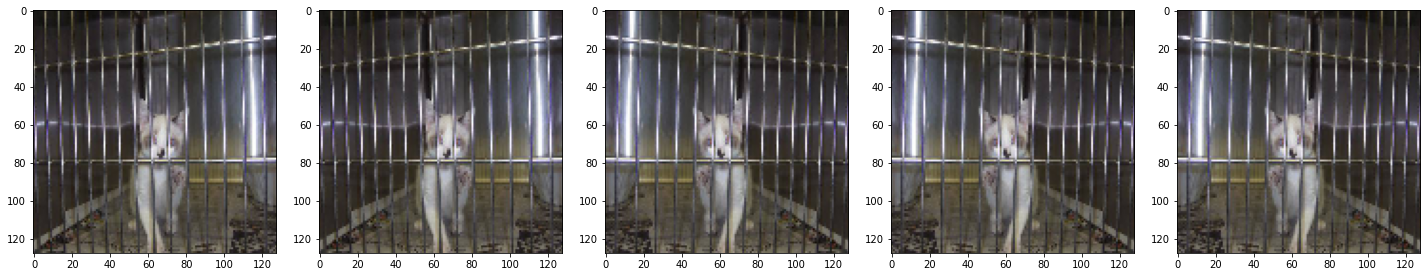

In [8]:
image_generator = ImageDataGenerator(rescale=1./255, horizontal_flip=True)
show_augmentation(image_generator)

## Rotation

Found 22500 images belonging to 2 classes.


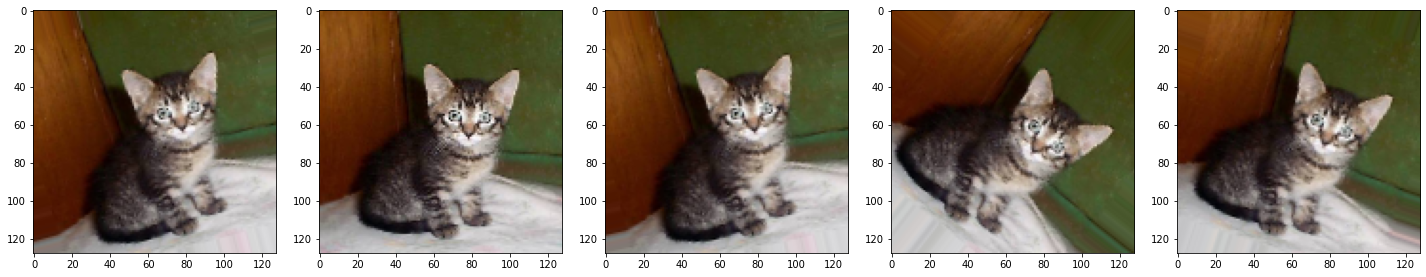

In [9]:
image_generator = ImageDataGenerator(rescale=1./255, rotation_range=45)
show_augmentation(image_generator)

## Zoom

Found 22500 images belonging to 2 classes.


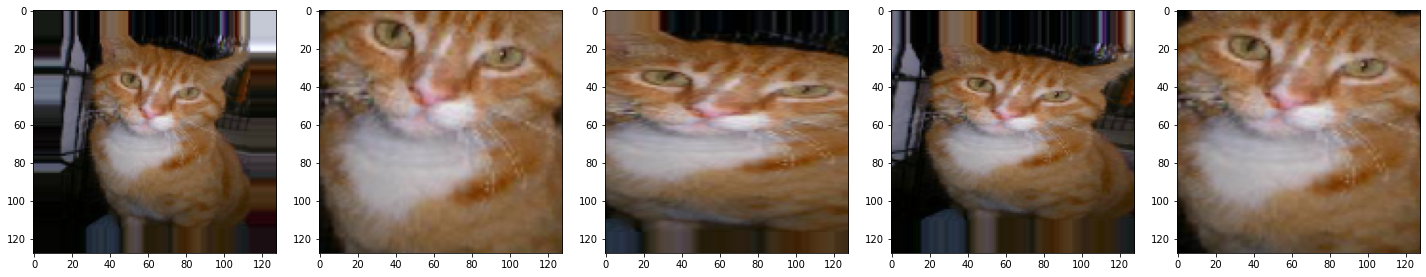

In [10]:
image_generator = ImageDataGenerator(rescale=1./255, zoom_range=0.5)
show_augmentation(image_generator)

## Putting it all together

Found 22500 images belonging to 2 classes.
Found 22500 images belonging to 2 classes.


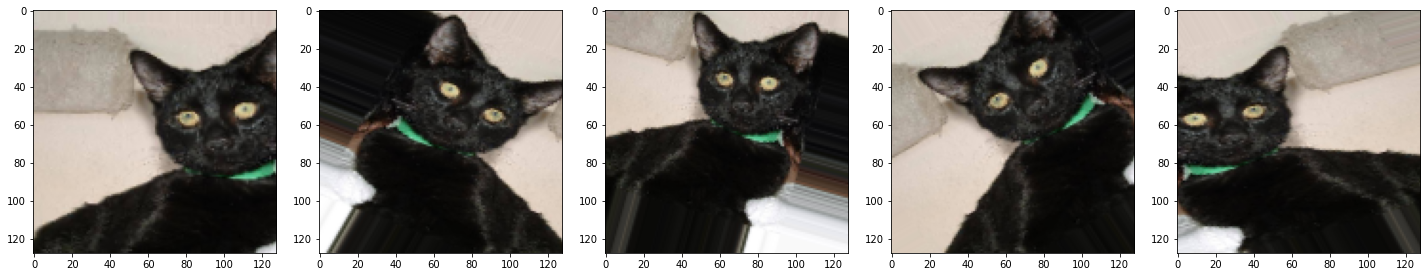

In [11]:
image_generator = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=1./255
)
train_data = image_generator.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(IMAGE_SHAPE, IMAGE_SHAPE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='binary'
)
show_augmentation(image_generator)

# Valid data

In [12]:
valid_generator = ImageDataGenerator(rescale=1./255)
valid_data = valid_generator.flow_from_directory(
    directory=VALID_DIR,
    target_size=(IMAGE_SHAPE, IMAGE_SHAPE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 2500 images belonging to 2 classes.


# Model
With dropout layer.

In [13]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=(3, 3),
        activation='relu',
        input_shape=(IMAGE_SHAPE, IMAGE_SHAPE, 3)
    ),
    tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    # dropout layer
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(units=2, activation='softmax')
])

2021-11-15 15:24:53.687701: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-15 15:24:53.789673: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-15 15:24:53.790723: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-15 15:24:53.794110: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [14]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 128)       1

In [16]:
EPOCHS = 60
history = model.fit_generator(
    generator=train_data,
    steps_per_epoch=(train_total + BATCH_SIZE - 1) // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=valid_data,
    validation_steps=(valid_total + BATCH_SIZE - 1) // BATCH_SIZE,
)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2021-11-15 15:24:58.396844: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/60


2021-11-15 15:25:00.997238: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


176/176 [==============================] - 158s 855ms/step - loss: 0.6703 - accuracy: 0.5792 - val_loss: 0.6498 - val_accuracy: 0.5888
Epoch 2/60
176/176 [==============================] - 148s 843ms/step - loss: 0.6128 - accuracy: 0.6587 - val_loss: 0.5310 - val_accuracy: 0.7456
Epoch 3/60
176/176 [==============================] - 147s 832ms/step - loss: 0.5750 - accuracy: 0.6989 - val_loss: 0.5101 - val_accuracy: 0.7432
Epoch 4/60
176/176 [==============================] - 148s 839ms/step - loss: 0.5458 - accuracy: 0.7236 - val_loss: 0.4816 - val_accuracy: 0.7828
Epoch 5/60
176/176 [==============================] - 149s 845ms/step - loss: 0.5238 - accuracy: 0.7388 - val_loss: 0.4205 - val_accuracy: 0.8200
Epoch 6/60
176/176 [==============================] - 146s 832ms/step - loss: 0.4927 - accuracy: 0.7653 - val_loss: 0.4761 - val_accuracy: 0.7688
Epoch 7/60
176/176 [==============================] - 149s 845ms/step - loss: 0.4637 - accuracy: 0.7826 - val_loss: 0.4193 - val_accura

# Train visualization
Look at it and compare with the graph [here](http://https://www.kaggle.com/imcr00z/intro-to-cnn-dogs-vs-cats)

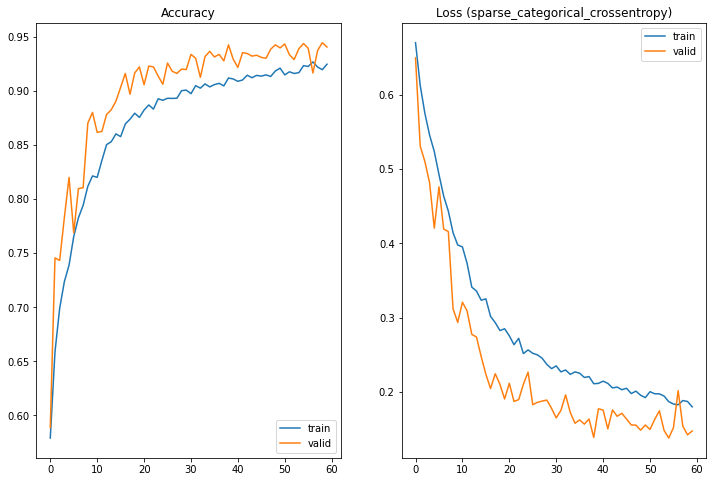

In [17]:
plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), history.history['accuracy'], label='train')
plt.plot(range(EPOCHS), history.history['val_accuracy'], label='valid')
plt.legend(loc='lower right')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), history.history['loss'], label='train')
plt.plot(range(EPOCHS), history.history['val_loss'], label='valid')
plt.legend(loc='upper right')
plt.title('Loss (sparse_categorical_crossentropy)')

plt.show()